In [1]:
import os
import torch
import scipy.io
import torch.nn as nn  # Import nn module
import torch.optim as optim  # Import optim module
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from hyperspectral_dataset import HyperspectralDataset, CustomTransform

from pnet import pNet

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
import torch
from torch.utils.data import DataLoader

# Function to get all file paths from a dataset
def get_all_file_paths(dataset):
    file_paths = []
    for idx in range(len(dataset)):
        file_paths.append(dataset.get_image_path(idx))
    return file_paths

# Initialize the dataset with transformations
dataset = HyperspectralDataset(root_dir='../../dibasRP/all')

# Define mean and std for cube and profile (replace these with actual values if available)
channel_means_cube = [0.5] * 31
channel_stds_cube = [0.5] * 31
channel_means_profile = [0.5] * 31
channel_stds_profile = [0.5] * 31

# Define the custom transformation including normalization and resizing
custom_transform = CustomTransform(
    cube_mean=channel_means_cube, 
    cube_std=channel_stds_cube, 
    profile_mean=channel_means_profile, 
    profile_std=channel_stds_profile,
    resize_shape=(224, 224)  # Resize cube to 224x224
)

# Apply the custom transforms to the datasets
train_dataset = HyperspectralDataset(root_dir='../../dibasRP/train', transform=custom_transform)
val_dataset = HyperspectralDataset(root_dir='../../dibasRP/val', transform=custom_transform)
test_dataset = HyperspectralDataset(root_dir='../../dibasRP/test', transform=custom_transform)

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

# Example to verify the changes
for sample, label in train_loader:
    print(f"Cube shape: {sample['cube'].shape}, Profile shape: {sample['profile'].shape}, Label: {label}")
    break

Label mapping: {'Acinetobacter_baumanii': 0, 'Lactobacillus_casei': 1, 'Lactobacillus_jehnsenii': 2, 'Lactobacillus_gasseri': 3, 'Lactobacillus_delbrueckii': 4, 'Lactobacillus_salivarius': 5, 'Propionibacterium_acnes': 6, 'Lactobacillus_paracasei': 7, 'Bifidobacterium_spp': 8, 'Lactobacillus_reuteri': 9, 'Staphylococcus_aureus': 10, 'Escherichia_coli': 11, 'Lactobacillus_rhamnosus': 12, 'Lactobacillus_plantarum': 13, 'Enterococcus_faecium': 14, 'Porfyromonas_gingivalis': 15, 'Enterococcus_faecalis': 16, 'Micrococcus_spp': 17, 'Fusobacterium': 18, 'Actinomyces_israeli': 19, 'Lactobacillus_crispatus': 20, 'Clostridium_perfringens': 21, 'Staphylococcus_epidermidis': 22, 'Listeria_monocytogenes': 23, 'Pseudomonas_aeruginosa': 24, 'Lactobacillus_johnsonii': 25, 'Streptococcus_agalactiae': 26, 'Staphylococcus_saprophiticus': 27, 'Bacteroides_fragilis': 28, 'Neisseria_gonorrhoeae': 29, 'Veionella': 30, 'Proteus': 31, 'Candida_albicans': 32}
Label mapping: {'Acinetobacter_baumanii': 0, 'Lactob

In [3]:
# Get file paths for the main dataset and each split
main_dataset_paths = get_all_file_paths(dataset)
train_dataset_paths = get_all_file_paths(train_dataset)
val_dataset_paths = get_all_file_paths(val_dataset)
test_dataset_paths = get_all_file_paths(test_dataset)

# Check if the total length of the splits equals the length of the main dataset
total_split_length = len(train_dataset_paths) + len(val_dataset_paths) + len(test_dataset_paths)
if total_split_length != len(main_dataset_paths):
    print(f"Error: Total length of splits ({total_split_length}) does not equal length of main dataset ({len(main_dataset_paths)})")
else:
    print("Total length of splits matches the length of the main dataset.")

# Check for overlaps between splits
def check_for_overlaps(paths1, paths2):
    overlaps = set(paths1) & set(paths2)
    return overlaps

train_val_overlaps = check_for_overlaps(train_dataset_paths, val_dataset_paths)
train_test_overlaps = check_for_overlaps(train_dataset_paths, test_dataset_paths)
val_test_overlaps = check_for_overlaps(val_dataset_paths, test_dataset_paths)

if train_val_overlaps:
    print(f"Error: Overlaps found between train and validation datasets: {len(train_val_overlaps)} overlaps")
else:
    print("No overlaps found between train and validation datasets.")

if train_test_overlaps:
    print(f"Error: Overlaps found between train and test datasets: {len(train_test_overlaps)} overlaps")
else:
    print("No overlaps found between train and test datasets.")

if val_test_overlaps:
    print(f"Error: Overlaps found between validation and test datasets: {len(val_test_overlaps)} overlaps")
else:
    print("No overlaps found between validation and test datasets.")

Total length of splits matches the length of the main dataset.
No overlaps found between train and validation datasets.
No overlaps found between train and test datasets.
No overlaps found between validation and test datasets.


In [4]:
model = pNet().to(device)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

In [6]:
import time
from sklearn.metrics import precision_recall_fscore_support

# Initialize lists to store losses, accuracy, and learning rate change epochs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
train_recalls = []
train_f1_scores = []
val_precisions = []
val_recalls = []
val_f1_scores = []
lr_change_epochs = []

# Training and validation loop
num_epochs = 125  # Set the number of epochs
for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start timing the epoch

    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_train_labels = []
    all_train_preds = []

    for batch_idx, (sample, labels) in enumerate(train_loader):
        profiles = sample['profile']  # Extract profile from the dictionary
        profiles, labels = profiles.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(profiles)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Store labels and predictions for precision, recall, f1
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(predicted.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Calculate precision, recall, f1 score for training
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(all_train_labels, all_train_preds, average='weighted', zero_division=0)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Precision: {train_precision:.3f}, Recall: {train_recall:.3f}, F1 Score: {train_f1:.3f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_val_labels = []
    all_val_preds = []

    with torch.no_grad():
        for sample, labels in val_loader:
            profiles = sample['profile']  # Extract profile from the dictionary
            profiles, labels = profiles.to(device), labels.to(device)  # Move data to GPU
            outputs = model(profiles)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            # Store labels and predictions for precision, recall, f1
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(predicted.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Calculate precision, recall, f1 score for validation
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(all_val_labels, all_val_preds, average='weighted', zero_division=0)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Precision: {val_precision:.3f}, Recall: {val_recall:.3f}, F1 Score: {val_f1:.3f}")

    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < current_lr:
        print(f"Learning rate reduced from {current_lr} to {new_lr}")
        lr_change_epochs.append(epoch+1)  # Log the epoch where the learning rate changed

    epoch_end_time = time.time()  # End timing the epoch
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f} seconds")

print("Training complete.")


Epoch [1/125], Loss: 3.4489, Training Accuracy: 9.33%, Precision: 0.030, Recall: 0.093, F1 Score: 0.042
Validation Loss: 3.4126, Validation Accuracy: 14.47%, Precision: 0.026, Recall: 0.145, F1 Score: 0.043
Epoch [1/125] completed in 1.97 seconds
Epoch [2/125], Loss: 3.4007, Training Accuracy: 14.55%, Precision: 0.039, Recall: 0.146, F1 Score: 0.055
Validation Loss: 3.3584, Validation Accuracy: 19.74%, Precision: 0.077, Recall: 0.197, F1 Score: 0.092
Epoch [2/125] completed in 1.87 seconds
Epoch [3/125], Loss: 3.3620, Training Accuracy: 18.28%, Precision: 0.071, Recall: 0.183, F1 Score: 0.094
Validation Loss: 3.3245, Validation Accuracy: 23.68%, Precision: 0.111, Recall: 0.237, F1 Score: 0.132
Epoch [3/125] completed in 1.94 seconds
Epoch [4/125], Loss: 3.3134, Training Accuracy: 23.51%, Precision: 0.113, Recall: 0.235, F1 Score: 0.140
Validation Loss: 3.3368, Validation Accuracy: 19.74%, Precision: 0.083, Recall: 0.197, F1 Score: 0.099
Epoch [4/125] completed in 1.97 seconds
Epoch [5/

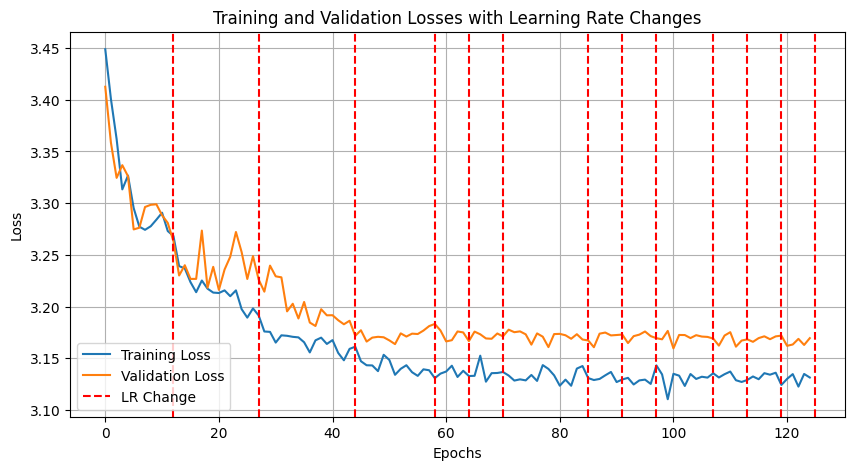

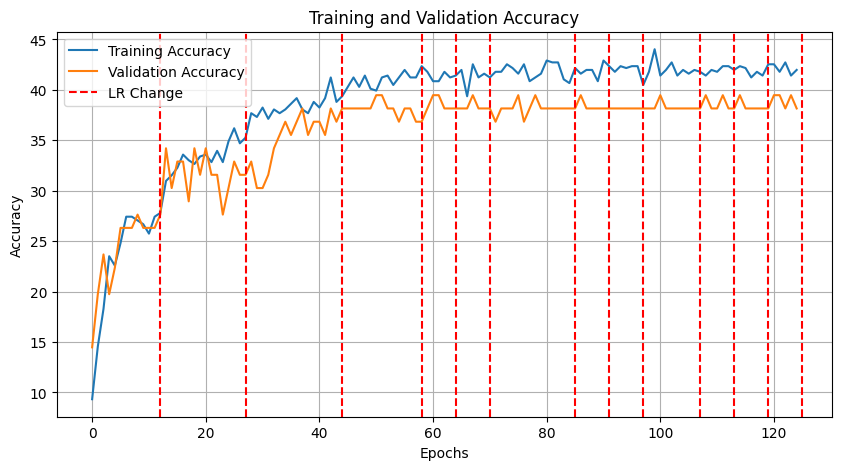

In [7]:
# Plot the training and validation losses with learning rate change points
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses with Learning Rate Changes')
plt.grid(True)  # Add gridlines
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)  # Add gridlines
plt.show()


<Figure size 1000x1000 with 0 Axes>

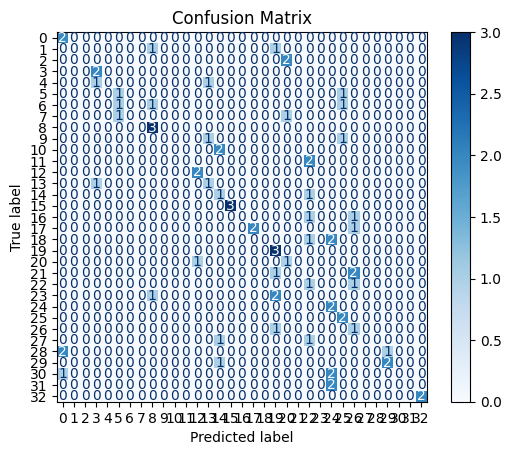

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to test an individual sample and collect predictions and true labels
def test_individual_test_sample(sample_idx, true_labels, predicted_labels):
    # Load a specific sample from the test dataset
    cube, label = test_dataset[sample_idx]
    
    # Move the sample to GPU if using CUDA
    cube = cube['profile'].to(device).unsqueeze(0)  # Add batch dimension
    label = label.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient computation for inference
    with torch.no_grad():
        output = model(cube)
    
    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(output, dim=1)
    
    # Get the predicted class
    predicted_class = torch.argmax(probabilities, dim=1)
    
    # Append the true and predicted labels to their respective lists
    true_labels.append(label.item())
    predicted_labels.append(predicted_class.item())

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Test individual samples and collect labels
for i in range(len(test_dataset)):
    test_individual_test_sample(i, true_labels, predicted_labels)

# Convert lists to numpy arrays for compatibility with sklearn
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [16]:
torch.save(model.state_dict(), 'pnet.pth')

In [17]:
for name, param in model.named_parameters():
    print(name)

conv1.weight
conv1.bias
batch_norm1.weight
batch_norm1.bias
dense1.weight
dense1.bias
dense2.weight
dense2.bias
